In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy import stats
from scipy.fftpack import fft, ifft
import bisect 
from scipy import signal
import pandas as pd
import seaborn as sns
from cdt.metrics import SHD
from cdt.metrics import precision_recall
import time
import random
import heapq
import lingam
import warnings

from spikegraph import *
from helpers import *

warnings.filterwarnings("ignore")

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
fn1='data/groundtruth/toyexample5nodegt_notDAG.txt'
gt = getGroundTruth(fn1)

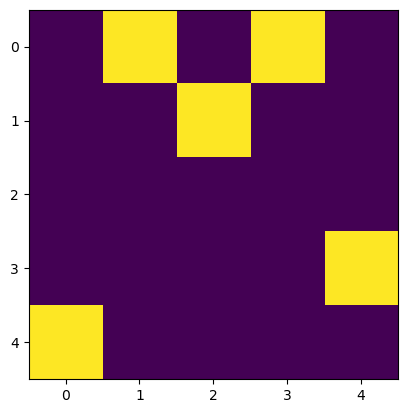

In [3]:
plt.imshow(gt)

K, T: (961, 41)
Unique elements and their counts:
Element: 0, Count: 30269
Element: 24, Count: 337
Element: 1, Count: 1538
Element: 2, Count: 1828
Element: 17, Count: 709
Element: 12, Count: 351
Element: 16, Count: 1548
Element: 3, Count: 596
Element: 8, Count: 816
Element: 4, Count: 697
Element: 19, Count: 82
Element: 18, Count: 425
Element: 26, Count: 82
Element: 20, Count: 41
Element: 11, Count: 41
Element: 5, Count: 41
Counter({0: 30269, 2: 1828, 16: 1548, 1: 1538, 8: 816, 17: 709, 4: 697, 3: 596, 18: 425, 12: 351, 24: 337, 19: 82, 26: 82, 20: 41, 11: 41, 5: 41})
[tab] 0000  tot=17.3190  var=0.0001  nll=3.4638
[tab] 0050  tot=2.6076  var=0.0460  nll=0.5123
[tab] 0100  tot=2.6329  var=0.0676  nll=0.5131
[tab] 0150  tot=2.9522  var=0.0570  nll=0.5790
[tab] 0200  tot=2.8534  var=0.0463  nll=0.5614
[tab] 0250  tot=2.5078  var=0.0715  nll=0.4873
[tab] 0300  tot=2.2411  var=0.0366  nll=0.4409
[tab] 0350  tot=3.0610  var=0.0571  nll=0.6008
[tab] 0400  tot=3.0779  var=0.0529  nll=0.6050
[t

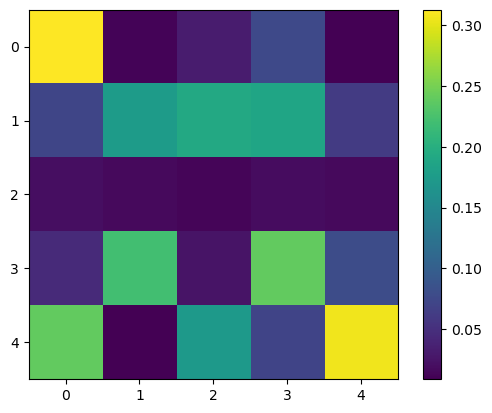

In [4]:
fn2 = f'data/spiketrainsfromNEURON/toyexampleNotDAG5nodesamples/rasterplot-5node_0.txt'

duration = 5000
N = 5
h = 5
T = 40
states_np, idx = enumerate_states(N)

numSpikes, spikeTimes = getSpikesInfo(fn2)
data = getBinarizedSpikeMatrix(spikeTimes, 5, N, h) # for 5 seconds

paths = prepare_paths_from_spikes(data, T)

K, T = np.shape(paths)
print(f"K, T: {K, T}")
print(count_unique_elements(paths))

@dataclass
class CFG:
    N: int = N
    T: int = T
    K: int = K
    seed: int = 123
    lr_tab: float = 1e-1
    iters_tab: int = 500
    lr_nn: float = 3e-4
    iters_nn: int = 1500
    hidden: int = 64
    batch_m: int = 256
    nll_coeff: float = 5.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG(N=N, T=T-1, K=K)
device = torch.device(cfg.device)
paths_t = torch.tensor(paths, device=device)

# Train transition matrix
P_tab, loss_tab_tot, loss_tab_var, loss_tab_nll = train_tabular(cfg, states_np, paths_t, device)
Δ_tab = influence(P_tab, states_np); Adj_tab = adjacency(Δ_tab)
plt.imshow(Δ_tab)
plt.colorbar()